## <b>Tensorflow basics</b>

#### Tensors

Tensorflow operrates on multidiamentional array or tensors represented as tf.Tensor objects.
Here two diamentional tensor :

In [10]:
import tensorflow as tf

x= tf.constant([[1,2,3],
               [4,5,6]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
(2, 3)
<dtype: 'int32'>


#### Operations

In [2]:
x + x

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]])>

In [3]:
5 * x

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 5, 10, 15],
       [20, 25, 30]])>

In [4]:
x @ tf.transpose(x)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]])>

In [5]:
tf.concat([x, x, x], axis=0)

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])>

Running large calculations on CPU can be slow. When properly configured, TensorFlow can use accelerator hardware like GPUs to execute operations very quickly.

In [12]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


#### Variables

Normal tf.Tensor objects are immutable. To store model weights (or other mutable state) in TensorFlow use a tf.Variable.

In [13]:
var = tf.Variable([0,0,0])

In [14]:
var.assign([2,3,6])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([2, 3, 6])>

In [16]:
var.assign_add([1,1,1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 4, 7])>

#### Automatic differentiation

Gradient descent and related algorothms are a cornerstone of modern machine learning.

To enable this, TensorFlow implements automatic differentiation (autodiff), which uses calculus to compute gradients. Typically you'll use this to calculate the gradient of a model's error or loss with respect to its weights.

In [17]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

In [18]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [19]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx

g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

#### Graphs and tf.function

While you can use TensorFlow interactively like any Python library, TensorFlow also provides tools for:

Performance optimization: to speed up training and inference.<br>
Export: so you can save your model when it's done training.<br>
These require that you use tf.function to separate your pure-TensorFlow code from Python.

In [20]:
@tf.function
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)

The first time you run the tf.function, although it executes in Python, it captures a complete, optimized graph representing the TensorFlow computations done within the function.

In [22]:
x = tf.constant([1, 2, 3])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [23]:
x = tf.constant([10, 9, 8])
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

A graph may not be reusable for inputs with a different signature (shape and dtype), so a new graph is generated instead:

In [24]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

These captured graphs provide two benefits:

In many cases they provide a significant speedup in execution (though not this trivial example).<br>
You can export these graphs, using tf.saved_model, to run on other systems like a server or a mobile device, no Python installation required.
Refer to Intro to graphs for more details.

#### Modules, layers, and models

tf.Module is a class for managing your tf.Variable objects, and the tf.function objects that operate on them. The tf.Module class is necessary to support two significant features:

1. You can save and restore the values of your variables using tf.train.Checkpoint. This is useful during training as it is quick to save and restore a model's state.
2. You can import and export the tf.Variable values and the tf.function graphs using tf.saved_model. This allows you to run your model independently of the Python program that created it.

Here is a complete example exporting a simple tf.Module object:

In [25]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

In [26]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

In [27]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved\assets


The resulting SavedModel is independent of the code that created it. You can load a SavedModel from Python, other language bindings, or TensorFlow Serving. You can also convert it to run with TensorFlow Lite or TensorFlow JS.

In [28]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

### Training loops

Now put this all together to build a basic model and train it from scratch.

First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:

In [29]:
import matplotlib
from matplotlib import pyplot as plt 

matplotlib.rcParams['figure.figsize'] = [9,6]

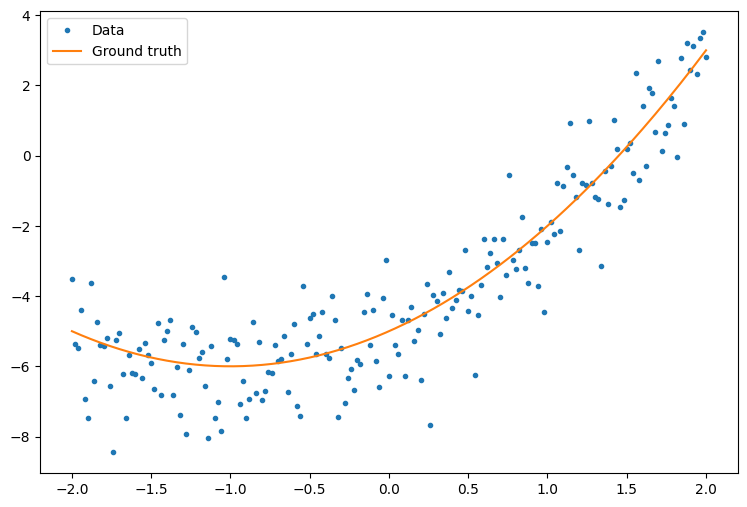

In [32]:
x = tf.linspace(-2,2,201)
x = tf.cast(x, tf.float32)

def f(x):
    y = x**2 + 2*x -5
    return y
y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

Create a quadratic model with randomly initialized weights and a bias:

In [ ]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

First, observe your model's performance before training:

In [34]:
quad_model = Model()

In [40]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

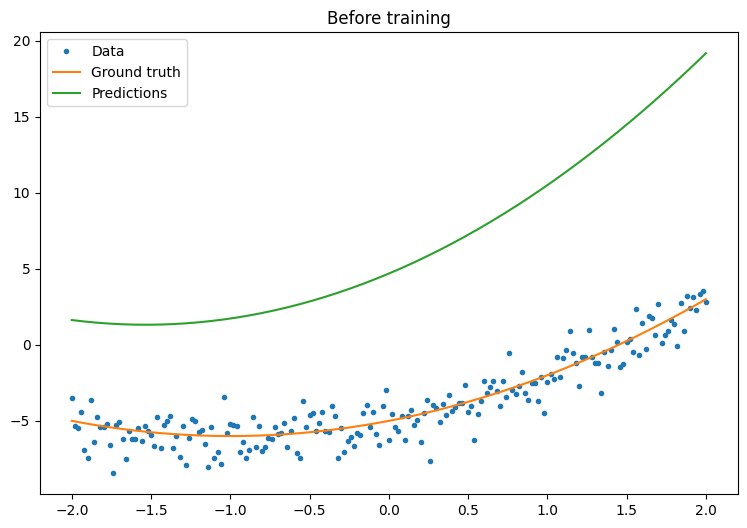

In [41]:
plot_preds(x, y, f, quad_model, 'Before training')

Now, define a loss for your model:

Given that this model is intended to predict continuous values, the mean squared error (MSE) is a good choice for the loss function. Given a vector of predictions, 
, and a vector of true targets, 
, the MSE is defined as the mean of the squared differences between the predicted values and the ground truth.




In [42]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

Write a basic training loop for the model. The loop will make use of the MSE loss function and its gradients with respect to the input in order to iteratively update the model's parameters. Using mini-batches for training provides both memory efficiency and faster convergence. The tf.data.Dataset API has useful functions for batching and shuffling.

In [43]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)